<div style="background:#FFFFFF">
<!-- <img src="../images/dataset-cover.jpg" width=150 ALIGN="left" style='margin-right:10px; border-style: solid; border-width: 2px;' alt='logo'> -->
<h1>Starting Kit - Style-Trans-Fair </h1>
<p>
This starting kit will guide you step by step and will walk you through the data statistics and<br>
examples. This will give you a clear idea of what this challenge is about and how you can<br>
proceed further to solve the challenge.
</p>

<br><br>
<hr style='background-color: #D3D3D3; height: 1px; border: 0;'>
<p>
This code was tested with Python 3.8.5 |Anaconda custom (64-bit)| (default, Dec 23 2020, 21:19:02) (https://anaconda.org/)<br>
</p>
<hr style='background-color: #D3D3D3; height: 1px; border: 0;'>
    
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</p>

<hr style='background-color: #D3D3D3; height: 1px; border: 0;'>
    <p>
This challenge was organized by <b>Team Fairness National Assembly</b> of <b><a style='color:#4D6605;' href='http://www.chalearn.org/'>ChaLearn</a></b>  at <b><a style='color: #62023C;' href='https://www.universite-paris-saclay.fr/'>Université Paris Saclay</a></b>
</p>
</div>

<hr style='background-color: #D3D3D3; height: 1px; border: 0;'>

***
# Introduction

This challenge uses a Dataset from ***Meta Album***. There are 5 tasks in the Development phase and 5 tasks in the Final Phase.
Each task in the dataset consists of **360** images splited into 9 groups:


where the training set is biased in Style, and the test set is balanced.

The sample dataset in this starting kit conists of **360** images of the Insect classification task.
    
This challenge is about creating a Machine Learning model and train it with the data provided to classify the images into the mentioned 3 Classes without being biased towards Styles.


**References and credits:**  
 - Meta Album (https://meta-album.github.io/)  
 - Université Paris Saclay (https://www.universite-paris-saclay.fr/)  
 - ChaLearn (http://www.chalearn.org/)  
***

### Install required packages

In [7]:
# !pip3 install scikit-image

### Imports

In [8]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from PIL import Image
from sklearn.decomposition import PCA
import os

In [9]:
model_dir = 'sample_code_submission/' # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%reload_ext autoreload

***
# Step 1: Exploratory data analysis
We provide `sample_data` with the starting kit, but to prepare your submission, you must fetch the `public_data` from the challenge website and point to it.

The data used for this challenge has images resized into 512x512 pixels.

In [11]:
data_name = 'style_trans_fair_challenge' # DO NOT CHANGE
data_dir = os.path.join('sample_data', 'task1') # Change it to point to the directory with public_data
image_dir = os.path.join(data_dir, 'stylized')

### Load Data

In [12]:
from data_io import read_data
data, meta_data = read_data(data_dir, random_state=42)

###-------------------------------------###
### Checking Data
###-------------------------------------###


-------------------------------------
[+] Your dataset is in perfect format
-------------------------------------


###-------------------------------------###
### Loading Data
###-------------------------------------###


-------------------------------------
[+] Data loaded successfully
-------------------------------------


###-------------------------------------###
### Loading Images
###-------------------------------------###


-------------------------------------
[+] Images loaded successfully
-------------------------------------




### Data Statistics

In [13]:
print("Categories/Classes : ", np.unique(data['train_labels']))
print("Styles : ", np.unique(data['train_styles']))
print("Train Images:", len(data['train_images']))
print("Test Images:", len(data['test_images']))

Categories/Classes :  ['Apoidea' 'Elateroidea' 'Tenthredinoidea']
Styles :  ['autumn_leaves' 'number_one' 'trippy_flowers']
Train Images: 60
Test Images: 180


## Visualization

In [14]:
def print_style_transfer_samples(row):
    f, ax = plt.subplots(1, 3)
    f.set_figheight(5)
    f.set_figwidth(15)
    ax[0].imshow(Image.open(os.path.join(data_dir, 'content', row['ORIG_CATEGORY_FILE'].iloc[0])))
    ax[0].set_title('Original')
    ax[0].set_axis_off()
    ax[1].imshow(Image.open(os.path.join(data_dir, 'styles', row['ORIG_STYLE_FILE'].iloc[0])))
    ax[1].set_title('Style')
    ax[1].set_axis_off()
    ax[2].imshow(Image.open(os.path.join(data_dir, 'stylized', row['FILE_NAME'].iloc[0])))
    ax[2].set_title('Stylized')
    ax[2].set_axis_off()

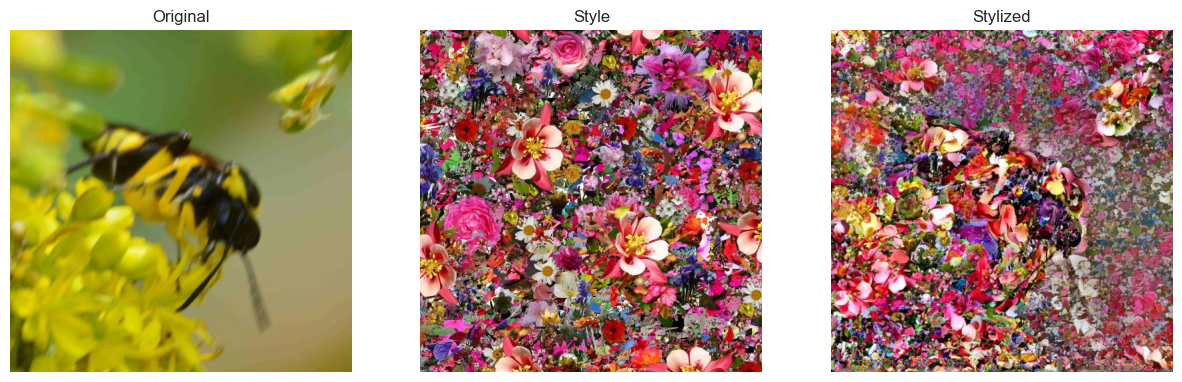

In [15]:
print_style_transfer_samples(data['train_df'].sample(1))

### Distribution of Classes/Labels

#### Train

In [16]:
grouped = data['train_df'].groupby(["CATEGORY", "STYLE"]).size().reset_index(name="COUNT")
grouped

,CATEGORY,STYLE,COUNT
0,Apoidea,autumn_leaves,12
1,Apoidea,number_one,4
2,Apoidea,trippy_flowers,4
3,Elateroidea,autumn_leaves,4
4,Elateroidea,number_one,12
5,Elateroidea,trippy_flowers,4
6,Tenthredinoidea,autumn_leaves,4
7,Tenthredinoidea,number_one,4
8,Tenthredinoidea,trippy_flowers,12


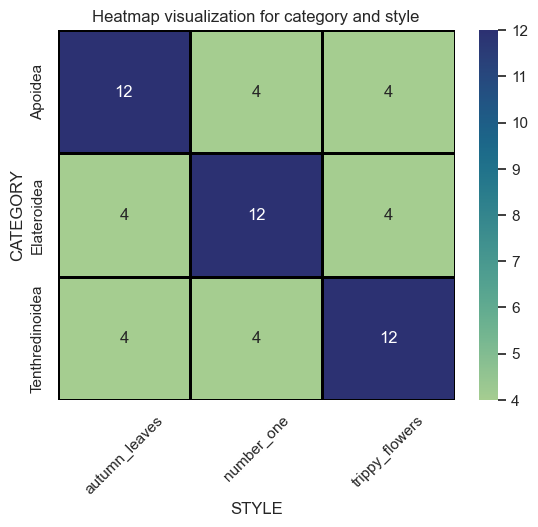

In [17]:
# Create the heatmap visualization for category and style
sns.heatmap(grouped.pivot("CATEGORY", "STYLE", "COUNT"), cmap="crest", annot=True, linewidths=1, linecolor='black')
plt.title('Heatmap visualization for category and style')
plt.xticks(rotation=45)
# Show the plot
plt.show()

#### Test

In [18]:
grouped = data['test_df'].groupby(["CATEGORY", "STYLE"]).size().reset_index(name="COUNT")
grouped

,CATEGORY,STYLE,COUNT
0,Apoidea,autumn_leaves,20
1,Apoidea,number_one,20
2,Apoidea,trippy_flowers,20
3,Elateroidea,autumn_leaves,20
4,Elateroidea,number_one,20
5,Elateroidea,trippy_flowers,20
6,Tenthredinoidea,autumn_leaves,20
7,Tenthredinoidea,number_one,20
8,Tenthredinoidea,trippy_flowers,20


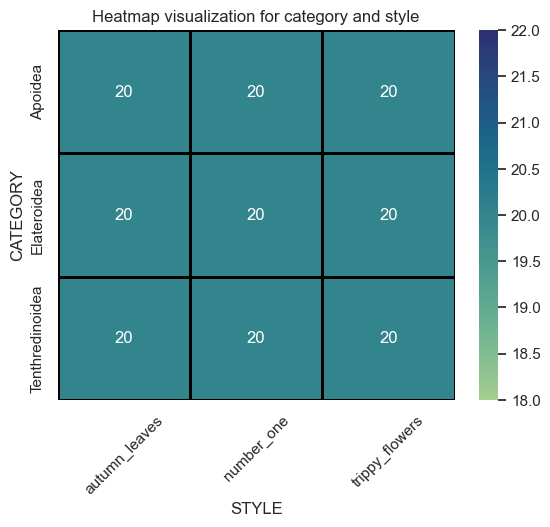

In [19]:
# Create the heatmap visualization for category and style
sns.heatmap(grouped.pivot("CATEGORY", "STYLE", "COUNT"), cmap="crest", annot=True, linewidths=1, linecolor='black')
plt.title('Heatmap visualization for category and style')
plt.xticks(rotation=45)
# Show the plot
plt.show()

### Further visualization

For further exploratory data analysis, we analyze the RGB color model and plot the graph. We get the mean for each channel of each image, and save it in the columns of a dataframe.

In [20]:
rgb = pd.DataFrame(
    np.zeros((len(data['train_df']), 5)), columns=list("RGB") + ["category", "style"]
)
for i in range(len(data['train_labels'])):
    img = data['train_images'][i]
    rgb.iloc[i, :3] = img.mean(axis=(0,1))
    rgb.iloc[i, 3] = data['train_labels'][i]
    rgb.iloc[i, 4] = data['train_styles'][i]
rgb.head()

,R,G,B,category,style
0,185.459820,123.966339,90.308178,Apoidea,autumn_leaves
1,198.923672,140.519848,100.388340,Apoidea,autumn_leaves
2,161.696911,107.406567,34.441048,Apoidea,autumn_leaves
3,178.202621,99.362495,25.698387,Apoidea,autumn_leaves
4,215.130695,89.868198,39.454258,Apoidea,autumn_leaves


We also normalize each color vector, so that we only care about the direction of the color vector and not about its magnitude.

In [21]:
pca = PCA(2)
rgb[list("rgb")] = rgb[list("RGB")] / np.sqrt(
    np.sum(np.square(rgb[list("RGB")]), axis=1).values.reshape(-1, 1)
) 

transformed_rgb = pca.fit_transform(rgb[list("rgb")]) 
rgb[list("xy")] = transformed_rgb 
red, green, blue = pca.transform(np.identity(3))

/Users/ktgiahieu/miniconda3/envs/style-trans-fair/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


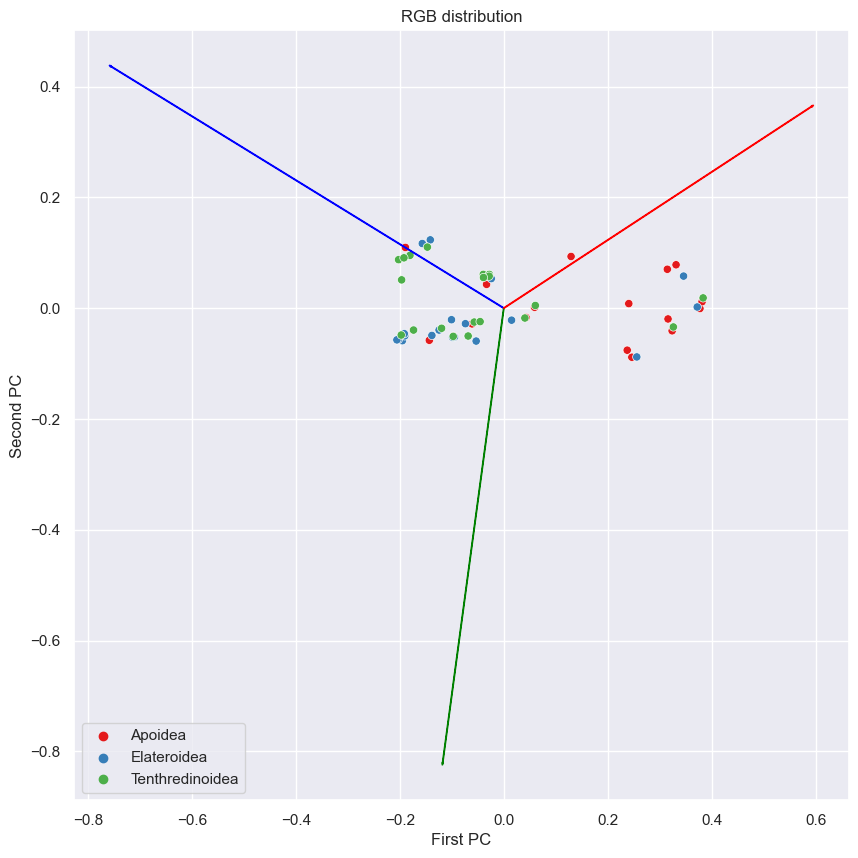

In [22]:
plot_data = rgb
plt.figure(figsize=(10, 10))
sns.scatterplot(x="x", y="y", hue="category", data=plot_data, palette="Set1")
plt.arrow(0, 0, *blue, color="blue")
plt.arrow(0, 0, *green, color="green")
plt.arrow(0, 0, *red, color="red")
plt.title("RGB distribution")
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.legend()
plt.show()

Next, we analyze the brightness of the images per category. We wanted to know which category has lower/higher brightness level so instead of using a simple mean for each RGB channel, we used a weighted mean that takes into account the perceived brightness by humans:
- Red: 21.26% 
- Green: 71.52% 
- Blue: 7.22%

In [23]:
BRIGHTNESS_VECTOR = np.array([0.2126, 0.7152, 0.0722])
rgb["brightness"] = (
    rgb[list("RGB")] @ BRIGHTNESS_VECTOR / 255
)
rgb.head()

,R,G,B,category,style,r,g,b,x,y,brightness
0,185.459820,123.966339,90.308178,Apoidea,autumn_leaves,0.770621,0.515104,0.375248,0.059244,0.001530,0.527881
1,198.923672,140.519848,100.388340,Apoidea,autumn_leaves,0.755135,0.533428,0.381085,0.042809,-0.016858,0.588388
2,161.696911,107.406567,34.441048,Apoidea,autumn_leaves,0.820171,0.544795,0.174694,0.246371,-0.088609,0.445806
3,178.202621,99.362495,25.698387,Apoidea,autumn_leaves,0.866558,0.483177,0.124965,0.323887,-0.040892,0.434531
4,215.130695,89.868198,39.454258,Apoidea,autumn_leaves,0.909791,0.380054,0.166853,0.331427,0.078275,0.442585


Using the boxplot we could easily identify the minimum, maximum, interquartile range, median and the outliers. Here we ordered it in respect to their lower quartile (Q1) to make it more representative.

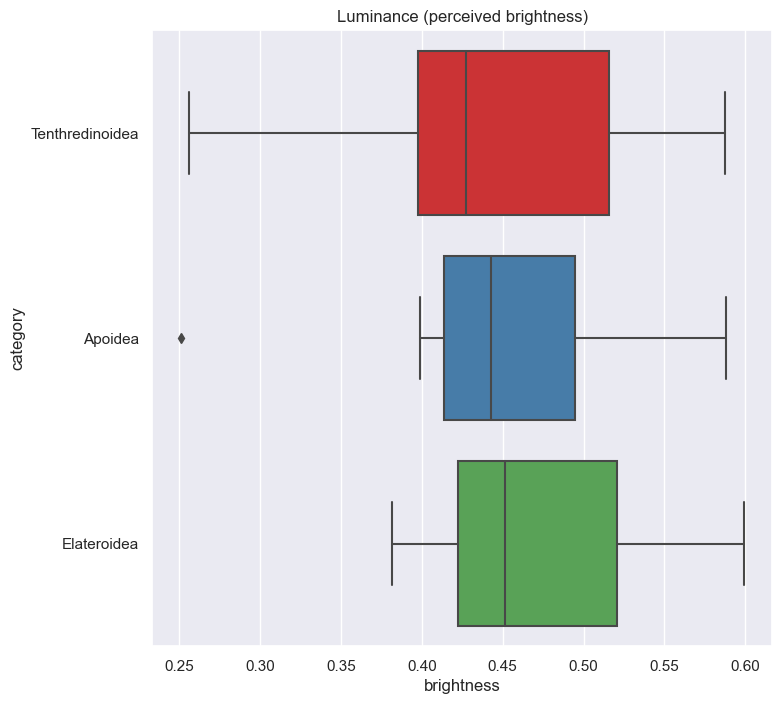

In [24]:
plot_data = rgb[["category", "brightness"]].copy()
order = plot_data.groupby("category")["brightness"].quantile(0.25).sort_values().index.tolist()
plt.figure(figsize=(8, 8))
sns.boxplot(y="category", x="brightness", data=plot_data, order=order, palette="Set1")
plt.title("Luminance (perceived brightness)") 
plt.show()

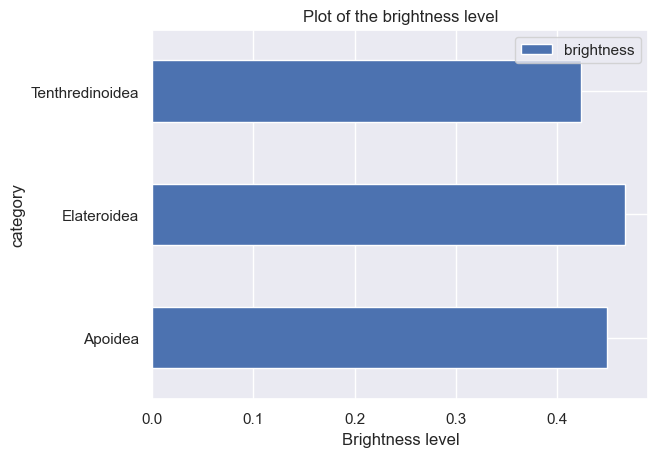

In [25]:
ax = pd.DataFrame(rgb.groupby("category")["brightness"].mean()).plot.barh()
plt.xlabel("Brightness level")
plt.title("Plot of the brightness level")
plt.show()

From the graph above we can conclude that the category Elateroidea has the highest value in term of brightness level

***
# Step 2: Building a predictive model


## Training a predictive model
We provide an example of predictive model in the `sample_code_submission/` directory. 
You can change this model and use a better one to get a good score for the challenge


**Install pre-requisites for using the model from Keras**

Uncomment the next line

In [26]:
from data_io import write
from model import model

<div style="background:#FFF">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
</div>

In [27]:
myModel = model()
trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
#myModel = myModel.load(trained_model_name) 

<div style="background:#FFF">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [28]:
X_TRAIN = data["train_images"]
STYLE_TRAIN = data["train_styles"]
Y_TRAIN = data["train_labels_num"]
X_TEST = data["test_images"]
STYLE_TEST = data["test_styles"]
Y_TEST = data["test_labels_num"]

In [29]:
if not(myModel.is_trained):
    myModel.fit(X_TRAIN, Y_TRAIN)                     

Y_hat_train = myModel.predict(X_TRAIN) # Optional, not really needed to test on taining examples
Y_hat_test = myModel.predict(X_TEST)

FIT: dim(X)= [60, 12288]
FIT: dim(y)= [60, 1]
PREDICT: dim(X)= [60, 12288]
PREDICT: dim(y)= [60, 1]
PREDICT: dim(X)= [180, 12288]
PREDICT: dim(y)= [180, 1]


**Save the trained model** (will be ready to reload next time around) and save the prediction results. <br>

In [30]:
myModel.save(trained_model_name)    

**IMPORTANT:** if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.

**REQUIRED:** Trained model is required in the submission to codalab. 

In [31]:
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_test.predict', Y_hat_test)

!ls $result_name*

sample_result_submission/style_trans_fair_challenge_test.predict
sample_result_submission/style_trans_fair_challenge_train.predict


## Scoring the results
### Load the challenge metric

**The metric chosen for your challenge** is identified in the "metric.txt" file found in the `scoring_program/` directory.
<br> 
The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.


In [32]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: geometric_mean_accuracy_metric


## Training performance

In [33]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_TRAIN, Y_hat_train, STYLE_TRAIN))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_TRAIN, Y_TRAIN, STYLE_TRAIN))

print('Test score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_TEST, Y_hat_test, STYLE_TEST))

Training score for the geometric_mean_accuracy_metric metric = 1.0000
Ideal score for the geometric_mean_accuracy_metric metric = 1.0000
Test score for the geometric_mean_accuracy_metric metric = 0.0000


You can add here other scores and result visualization.

## Confusion matrix

In [34]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(Y_TRAIN, Y_hat_train)

In [35]:
confusion_matrix

array([[20,  0,  0],
       [ 0, 20,  0],
       [ 0,  0, 20]])

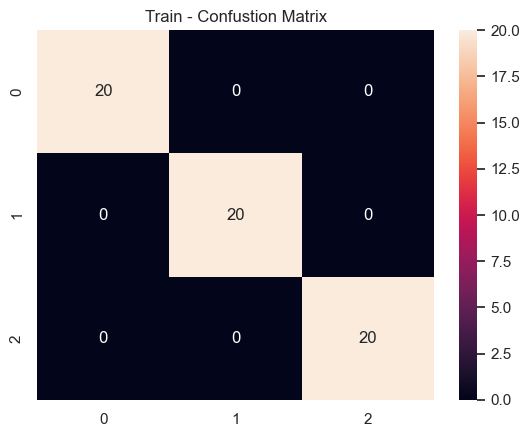

In [36]:
df_cm = pd.DataFrame(confusion_matrix, range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1]))
sns.heatmap(df_cm, annot=True)
plt.title("Train - Confustion Matrix")
plt.show()

***
# Step 3: Making a submission

## Unit testing

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

In [37]:
# !source activate python3; 
!python3 $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

Using input_dir: /Users/ktgiahieu/Documents/style-trans-fair/starting_kit/sample_data/task1
Using output_dir: /Users/ktgiahieu/Documents/style-trans-fair/starting_kit/sample_result_submission
Using program_dir: /Users/ktgiahieu/Documents/style-trans-fair/starting_kit/ingestion_program
Using submission_dir: /Users/ktgiahieu/Documents/style-trans-fair/starting_kit/sample_code_submission
Data name: style_trans_fair_challenge

========== Ingestion program version 6 ==========

************************************************
******** Processing dataset Style_trans_fair_challenge ********
************************************************
========= Reading and converting data ==========
###-------------------------------------###
### Checking Data
###-------------------------------------###


-------------------------------------
[+] Your dataset is in perfect format
-------------------------------------


###-------------------------------------###
### Loading Data
###-----------------------

### Test scoring program

In [47]:
scoring_output_dir = 'scoring_output'
# !source activate deeplearning; 
!python3 $score_dir/score.py $data_dir $result_dir $scoring_output_dir

###-------------------------------------###
### Using metric :  geometric_mean_accuracy_metric
###-------------------------------------###


###-------------------------------------###
### Train solutions :  60
### Test solutions :  180
###-------------------------------------###


###-------------------------------------###
### Solutions files are ready!
###-------------------------------------###


======= Set 1 (Style_trans_fair_challenge_train): geometric_mean_accuracy_metric(set1_score)=1.000000000000 =======
======= Set 2 (Style_trans_fair_challenge_test): geometric_mean_accuracy_metric(set2_score)=0.000000000000 =======


# Prepare the submission

In [48]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
# sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
# zipdir(sample_result_submission, result_dir)
print("Submit this file to codalab:\n" + sample_code_submission)

Submit this file to codalab:
../sample_code_submission_23-01-23-11-57.zip
